# __Table of Contents__

1. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [Description](#description)
    - [Visualize Data](#visualize-data)
    - [Descriptive Statistics](#descriptive-statistics)
    - [Target Variable](#target-variable)
    - [Data Distributions](#data-distributions)
    - [Feature Correlations](#feature-correlations)
2. [Clustering](#clustering)
    - [Generate Clusters](#generate-clusters)
    - [Plot Clusters](#plot-clusters)
    - [Cluster Insights](#cluster-insights)
3. [Predictive Modeling](#predictive-modeling)
    - [Model Selection](#model-selection)
    - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [Feature Importance](#feature-importance)
4. [Conclusions](#conclusions)
    - [Summary](#summary)
    - [Who is likeliest to cancel?](#who-is-likeliest-to-cancel)

# __Exploratory Data Analysis (EDA)__ <a name="exploratory-data-analysis-eda"></a>

## Description <a name="description"></a>

A gym is looking to better understand why its customers choose to cancel their memberships. They want to model this phenomenom (i.e., churn) and predict which future customers are most likely to cancel their memberships based on their gym-going habits and characteristics. A study of the gym's dataset is provided below. 

Data source: https://www.kaggle.com/datasets/adrianvinueza/gym-customers-features-and-churn/data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/gym_churn_us.csv')

## Visualize Data <a name="visualize-data"></a>

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Lowercase column names
df = df.rename(columns=lambda x: x.lower())

## Descriptive Statistics <a name="descriptive-statistics"></a>

In [7]:
df.describe().T.drop(['25%', '50%', '75%'], axis=1)

,count,mean,std,min,max
gender,4000.0,0.510250,0.499957,0.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,12.000000


As we can see, 6 of the 13 features are binary, and the other 7 are continuous:
- Binary: 
    - `gender`
    - `near_location`
    - `partner`
    - `promo_friends`
    - `phone`
    - `group_visits`
- Continuous: 
    - `contract_period`
    - `age`
    - `avg_additional_charges_total`
    - `month_to_end_contract`
    - `lifetime`
    - `avg_class_frequency_total`
    - `avg_class_frequency_current_month`

## Target Variable <a name="target-variable"></a>

The target variable for this problem is the `churn` variable, which indicates whether a customer has cancelled their gym membership (0 for non-cancellation, 1 for cancellation). This is the variable that we will be attempting to predict later on.

## Data Distributions <a name="data-distributions"></a>

In [8]:
def plot_distributions(df, hue, alpha):
    # Number of subplots
    nrows = int(np.ceil(len(df.columns) - 1 / 3))
    ncols = 3

    # Create figure
    fig = plt.figure(constrained_layout=True, figsize=(ncols*3.5, nrows*3.5))
    gs = fig.add_gridspec(nrows, ncols, wspace=0.1, hspace=0.1)

    for i, col in enumerate(df.columns):
        if col == 'churn':
            break

        # Create subplot
        subfig = fig.add_subfigure(gs[i // 3, i % 3])
        axs = subfig.subplots(2, 1)

        # Plot
        sns.histplot(data=df, x=col, bins='auto', palette=['green', 'red'], 
                     ax=axs[0], hue=hue, alpha=alpha)
        sns.boxplot(data=df, y=hue, palette=['green', 'red'], x=col, ax=axs[1], 
                    orient='h')

        # Style
        axs[0].set_xlabel('')
        subfig.suptitle(col.upper())
        subfig.set_facecolor('lightgrey')
    
    plt.show()

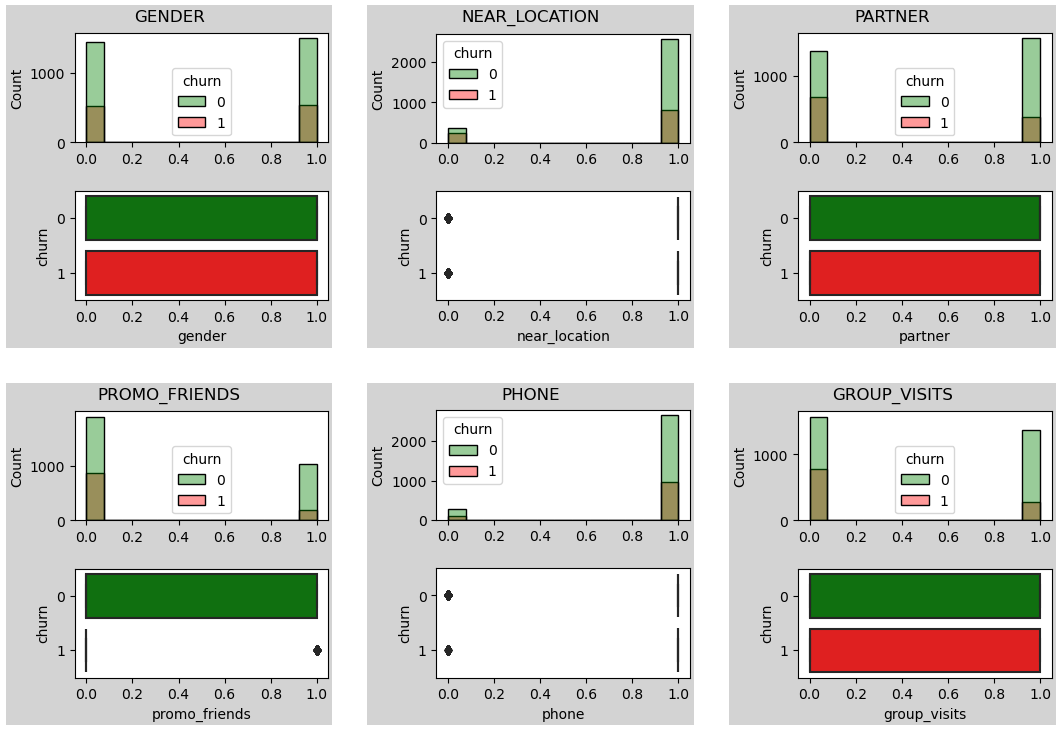

In [9]:
# Binary features
binary_features = ['gender', 'near_location', 'partner', 'promo_friends', 
                   'phone', 'group_visits', 'churn']
plot_distributions(df[binary_features], hue='churn', alpha=0.4)

The above histograms and boxplots show the distributions of each binary feature, grouped by their relationship to the target variable, churn. There doesn't seem to be anything very unusual here, but it must be noted that the __classes are quite imbalanced__ (i.e., there are roughly 3x as many non-churn data points as there are churn). To address this, we might need to balance the classes (e.g., downsampling and upsamling) later on.

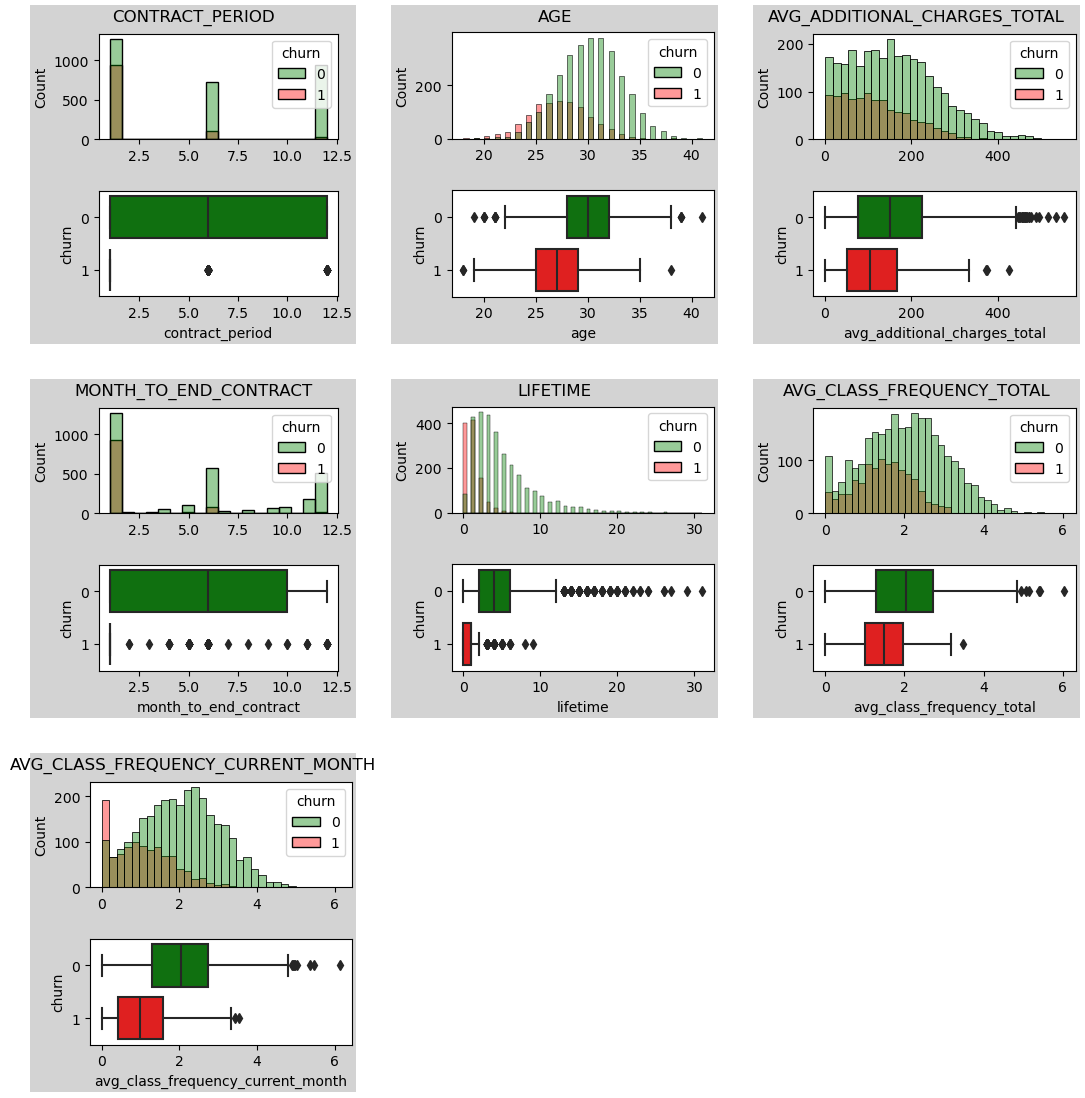

In [10]:
# Continuous features
continuous_features = ['contract_period', 'age', 'avg_additional_charges_total',
                       'month_to_end_contract', 'lifetime',
                       'avg_class_frequency_total', 
                       'avg_class_frequency_current_month', 'churn']
plot_distributions(df[continuous_features], hue='churn', alpha=0.4)

As with the binary variables, the distributions of the continuous features are shown above. At first glance, it appears that those __most likely to cancel their memberships__ have a __lower average age, attend fewer fitness classes, and sign up for shorter membership contracts__. These insights will be explored further in a later section. It should be noted that some of these distributions contain __fairly significant outliers__, which might need to be addressed if model performance is inadequate. 

Based on the distributions of binary and continuous features, the following observations can be made.

Clients who cancel their memberships are...
- Typically under 35 years old
- Have 1 month left on their contract
- Have shorter contract periods than non-cancelers
- Spend less on additional services than non-cancelers
- Have been members for fewer than 5 months
- Have attended fewer classes than non-cancelers

## Feature Correlations <a name="feature-correlations"></a>

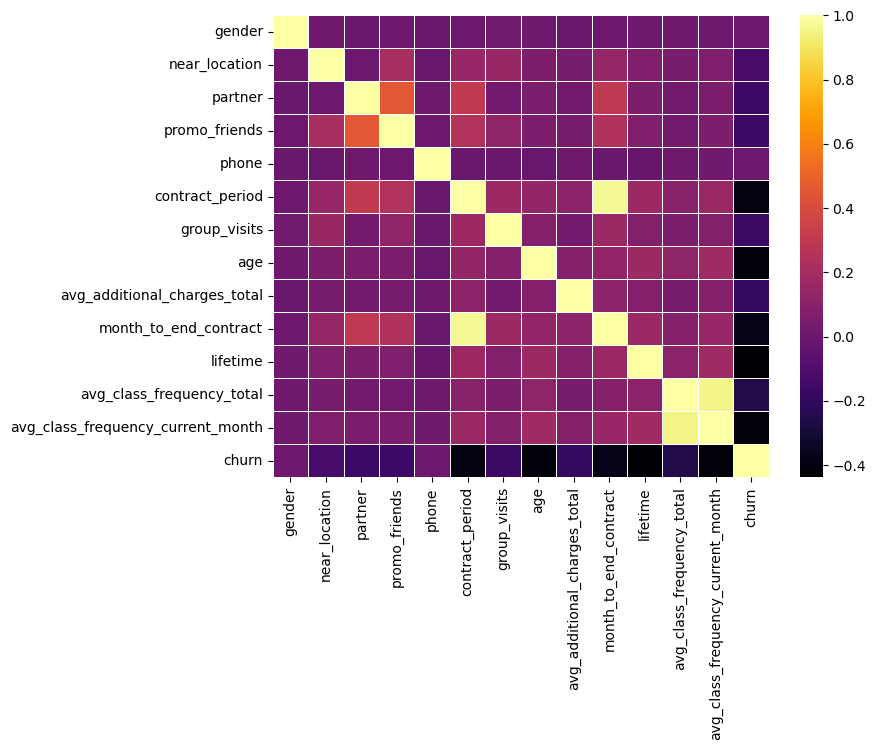

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), linewidths=.5, cmap='inferno')
plt.show()

The correlation matrix looks good, but there are two pairs of features that are very highly correlated (i.e., __collinear__):
- `contract_period`, `month_to_end_contract`
- `avg_class_frequency_current_month`, `avg_class_frequency_total`

I will fix this by removing `avg_class_frequency_total` and `contract_period` from the dataset.

In [12]:
df_cleaned = df.drop(['contract_period', 'avg_class_frequency_total'], axis = 1)

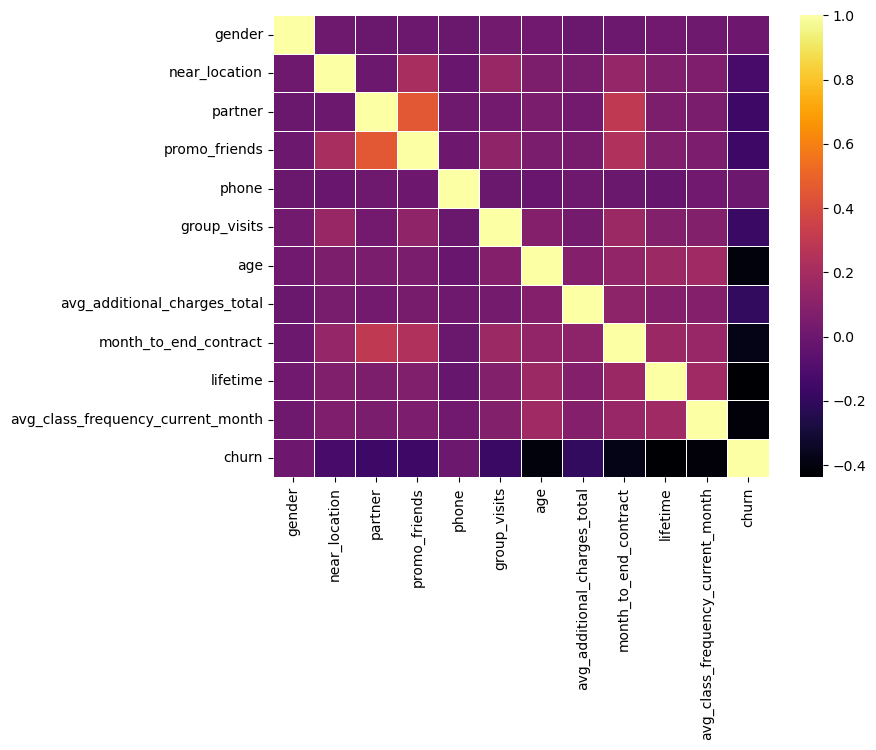

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_cleaned.corr(), linewidths=.5, cmap='inferno')
plt.show()

# __Clustering__ <a name="clustering"></a>

## Generate Clusters <a name="generate-clusters"></a>

To further understand the different characteristics of gym-goers who cancel and those who don't, I will group them into clusters. These clusters will concretely show how cancelers and non-cancelers differ along the different dimensions/features of our dataset.

In [48]:
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply K-Means
km = KMeans(n_clusters=3, n_init=10, random_state=42).fit(df_scaled)
labels = km.predict(df_scaled)

## Plot Clusters <a name="plot-clusters"></a>

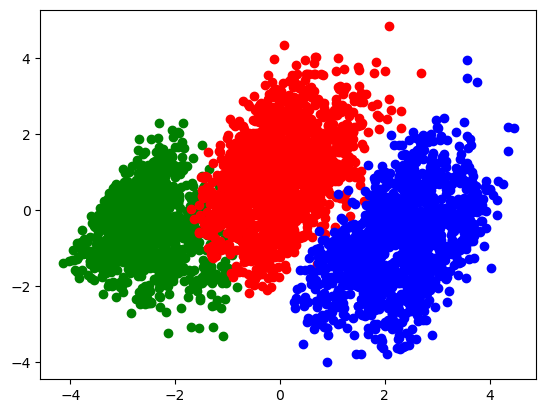

In [49]:
pca = PCA(n_components=2).fit_transform(df_scaled)
df_red = pd.DataFrame(pca, columns=['x', 'y'])
df_red['cluster']=labels
plt.scatter(df_red[df_red['cluster']==0]['x'], df_red[df_red['cluster']==0]['y'], c='green')
plt.scatter(df_red[df_red['cluster']==1]['x'], df_red[df_red['cluster']==1]['y'], c='red')
plt.scatter(df_red[df_red['cluster']==2]['x'], df_red[df_red['cluster']==2]['y'], c='blue')
plt.show()

In [50]:
df['cluster'] = labels
cluster_feature_means = df.groupby('cluster').mean()
cluster_feature_means.round(2).T

cluster,0,1,2
gender,0.51,0.50,0.52
near_location,0.76,0.83,0.94
partner,0.35,0.36,0.77
promo_friends,0.18,0.19,0.57
phone,0.91,0.90,0.90
contract_period,1.61,2.25,10.51
group_visits,0.26,0.41,0.55
age,26.93,30.17,29.87
avg_additional_charges_total,115.15,157.12,161.41
month_to_end_contract,1.56,2.13,9.57


## Cluster Insights <a name="cluster-insights"></a>

These clusters reveal some important information that builds on the EDA performed earlier. Clusters 1 and 2 reflect the gym-goers who did not cancel their memberships, while Cluster 0 mostly reflects gym-goers who did cancel. As such, the differences between Cluster 0 and the other two Clusters represent the differences between those who cancel and those who don't. 

__Cluster 0 (churn) vs Clusters 1, 2 (no churn)__:
- Cluster 0 __lives farther away__ from the gym
- Cluster 0 signs up for __shorter contract period__
- Cluster 0 makes __fewer group visits__
- Cluster 0 roughly __three years younger__ on average
- Cluster 0 spends __less on additional purchases__
- Cluster 0 has __less time remaining on contract__ 
- Cluster 0 has been a __member for 3 months less__ than Clusters 1, 2
- Cluster 0 has __attended 1 fewer classes in current month__ than Clusters 1, 2

These insights give us a profile of the customers who are most likely to cancel their memberships.

# __Predictive Modeling__ <a name="predictive-modeling"></a>

## Model Selection <a name="model-selection"></a>

For this binary classification problem, I will test the following models:
- Logistic Regression
- Linear SVM
- XGBoost

Since the gym is interested in identifying __all__ customers who are likely to cancel their memberships, we must place extra emphasis on recall scores.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from xgboost import XGBClassifier

seed = 42

# Splitting into features and target
X = df_cleaned.drop('churn', axis=1)
y = df_cleaned['churn']

# Splitting into train and test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=seed)

# Scaling to 0 mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_tr_scaled = scaler.fit_transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [16]:
# Instiating models
models = {'Logistic Regression': LogisticRegression(random_state=seed),
          'Linear SVM': LinearSVC(random_state=seed),
          'XGBoost': XGBClassifier(seed=seed)}

# Testing models
def test_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    print(name)
    print('Accuracy:', accuracy_score(y_te, y_pred))
    print('Precision:', precision_score(y_te, y_pred))
    print('Recall:', recall_score(y_te, y_pred))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.5})
    
    # Display Confusion Matrix
    cm = ConfusionMatrixDisplay.from_estimator(model, X_te, y_te,
                                                            normalize=None,
                                                            ax=axs[0])
    cm.ax_.set_title(f'Confusion Matrix ({name})')

    # Display ROC
    roc = RocCurveDisplay.from_estimator(model, X_te, y_te, ax=axs[1])
    roc.ax_.set_title(f'ROC Curve ({name})')
    plt.show()
    print()

Logistic Regression
Accuracy: 0.905
Precision: 0.8315789473684211
Recall: 0.7821782178217822


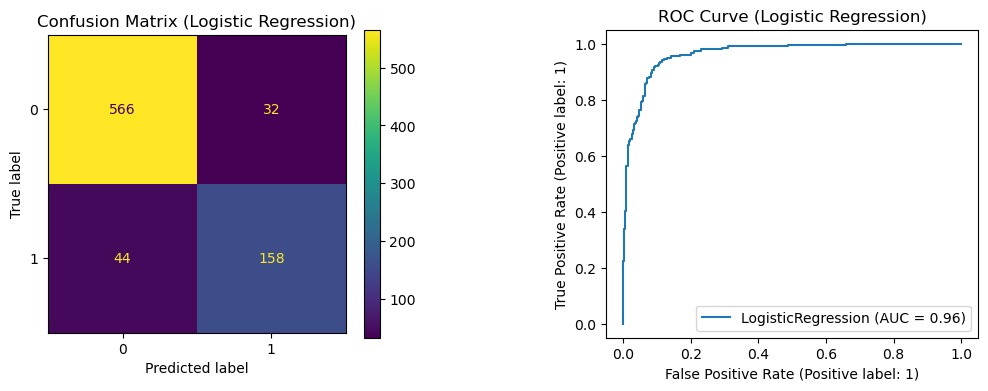

In [17]:
# Logistic Regression
test_model('Logistic Regression', models['Logistic Regression'], X_tr_scaled, y_tr, X_te_scaled, y_te)

Linear SVM
Accuracy: 0.90625
Precision: 0.8290155440414507
Recall: 0.7920792079207921


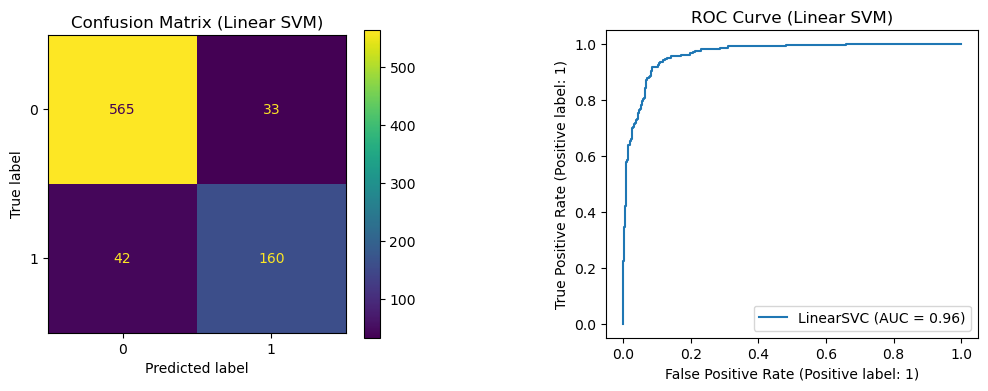

In [18]:
# Linear SVM
test_model('Linear SVM', models['Linear SVM'], X_tr_scaled, y_tr, X_te_scaled, y_te)

XGBoost
Accuracy: 0.885
Precision: 0.7925531914893617
Recall: 0.7376237623762376


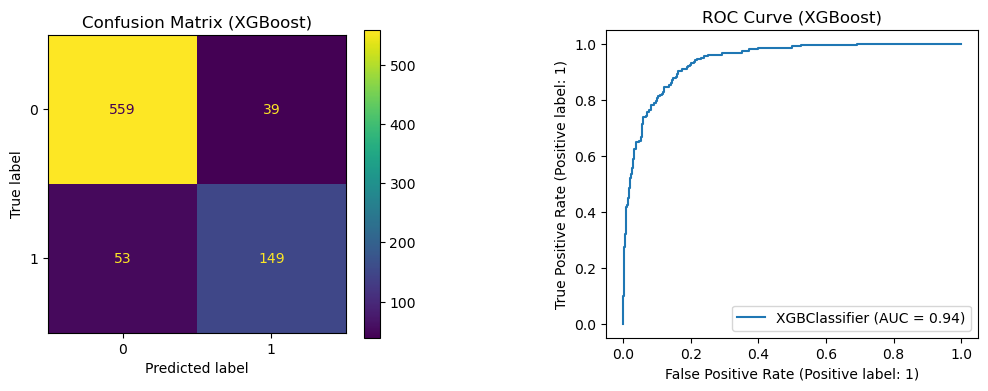

In [19]:
# XGBoost
test_model('XGBoost', models['XGBoost'], X_tr_scaled, y_tr, X_te_scaled, y_te)

## Hyperparameter Tuning <a name="hyperparameter-tuning"></a>

As expected, the most complex models doesn't perform well out of the box, likely requiring hyperparameter tuning. I will attempt to tune XGBoost's hyperparameters to see if performance can be improved before selecting a model.

In [20]:
def tune_hyperparameters():
    learning_rate = np.linspace(.4, .6, 4)
    min_child_weight = np.linspace(1, 3, 4)
    subsample = np.linspace(.5, 1, 4)
    n_estimators = np.linspace(100, 400, 4)
    r = 0
    for lr in learning_rate:
        for mcw in min_child_weight:
            for ss in subsample:
                for ne in n_estimators:
                    xgb = XGBClassifier(objective='binary:logistic', 
                                      learning_rate=lr, 
                                      max_depth=1,
                                      min_child_weight=int(mcw), 
                                      subsample=ss, 
                                      n_estimators=int(ne),
                                      random_state=seed)
                    xgb.fit(X_tr_scaled, y_tr)
                    y_pred = xgb.predict(X_te_scaled)
                    rec = recall_score(y_te, y_pred)
                    if rec > r:
                        r = rec
                        print('Recall:', r, 
                            'Learning rate:', lr, 
                            'Min child weight:', mcw, 
                            'Subsample:', ss, 
                            'N estimators:', ne)

tune_hyperparameters()

Recall: 0.7772277227722773 Learning rate: 0.4 Min child weight: 1.0 Subsample: 0.5 N estimators: 100.0
Recall: 0.7821782178217822 Learning rate: 0.4 Min child weight: 1.0 Subsample: 0.5 N estimators: 300.0
Recall: 0.7871287128712872 Learning rate: 0.4 Min child weight: 1.0 Subsample: 0.5 N estimators: 400.0
Recall: 0.7920792079207921 Learning rate: 0.4 Min child weight: 1.0 Subsample: 0.6666666666666666 N estimators: 100.0
Recall: 0.7970297029702971 Learning rate: 0.4 Min child weight: 1.0 Subsample: 1.0 N estimators: 100.0
Recall: 0.806930693069307 Learning rate: 0.4666666666666667 Min child weight: 1.0 Subsample: 0.5 N estimators: 100.0


XGBoost
Accuracy: 0.90875
Precision: 0.8274111675126904
Recall: 0.806930693069307


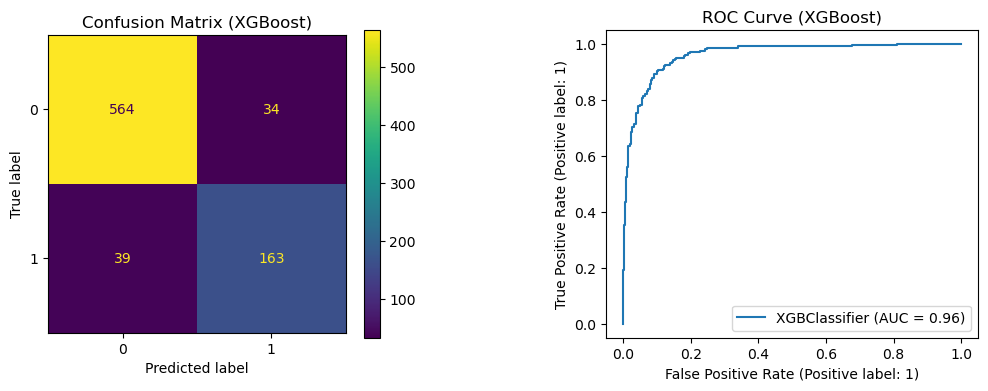

In [21]:
models['XGBoost'] = XGBClassifier(objective='binary:logistic', 
                                  learning_rate=0.467, 
                                  max_depth=1,
                                  min_child_weight=1, 
                                  subsample=0.5, 
                                  n_estimators=100,
                                  random_state=seed)

test_model('XGBoost', models['XGBoost'], X_tr_scaled, y_tr, X_te_scaled, y_te)

After hyperparameter tuning, XGBoost performs much better than Logistic Regression and slightly better than Linear SVM in terms of recall.

## Feature Importance <a name="feature-importance"></a>

In [22]:
fi = dict(zip(df_cleaned.columns[:-1], models['XGBoost'].feature_importances_))
fi_df = pd.DataFrame(data={'feature': fi.keys(), 'importance': fi.values()})
fi_df.sort_values(by='importance', ascending=False, inplace=True, ignore_index=True)
fi_df

,feature,importance
0,lifetime,0.358408
1,month_to_end_contract,0.196666
2,age,0.095170
3,avg_class_frequency_current_month,0.090184
4,promo_friends,0.063519
5,near_location,0.049971
6,group_visits,0.044614
7,avg_additional_charges_total,0.042625
8,gender,0.035744
9,phone,0.023100


# __Conclusions__ <a name="conclusions"></a>

## Summary <a name="summary"></a>

As revealed by the EDA, Clustering, and Predictive Modeling, the following features are most relevant for predicting churn:
- `lifetime`: how long person has been a member
- `month_to_end_contract`: how many months left on contract
- `age`: customer's age
- `avg_class_frequency_current_month`: how many classes customer has attended in current month
- `promo_friends`: whether customer signed up through a referral or not
- `contract_period`: the length of customer's membership contract
- `avg_additional_charges_total`: how much a customer has spent on additional services at the gym
- `group_visits`: how many group activities a customer is enrolled in

## Who is likeliest to cancel? <a name="who-is-likeliest-to-cancel"></a>

- __History:__ Customers are most likely to cancel when they are still new the most do not work in a company associated with the gym nor do they obtain a discount for enrolling a to the gym. The longer a person stays, the less likely they are to cancel.
- __Proximity:__ Customers are more likely to cancel if they live farther away from the gym.
- __Friends:__ Customers are less likely to cancel their memberships if they enrolled through a friend's promo code. It seems that customers who have friends at the gym tend to cancel less.
- __Contract:__ Customers with shorter contracts tend to cancel more frequently. This might be because customers who plan to stay longer may opt for longer contracts, while customers who simply want to "try out" the gym opt for shorter contracts.
- __Group Sessions:__ Participating in group sessions seems to encourage and motivate customers to continue at the gym.
- __Age:__ Customers who cancel are, on average, 3 three years younger than those who don't. This might be because young customers are more likely to move away from the gym or have less established routines.
- __Additional services:__ Customers who spend more on additional services tend to cancel less frequently, suggesting that as customers spend more, they become more associated with the gym.
- __Remaining period:__ Customers are most likely to cancel in the final two months of their contract periods.